## The process of a standard PyTorch Regression Exercise



$$\begin{array}{ll}
\text{Topic}&\text{Contents}\\
\hline
\text{1. Getting data ready}&\text{Data can be almost anything but to get started we're going}\\
&\text{to create a simple straight line}\\
\hline
\text{2. Building a model}&\text{Here we'll create a model to learn patterns in the data, we'll}\\
&\text{also choose a } \textbf{loss function}\text{ , }\textbf{optimizer} \text{ and build a }\\
&\textbf{training loop}\\
\hline
\text{3. Fitting the model to training}&\text{We've got data and a model, now let's let the model to find}\\
\text{ data}&\text{patterns in the training data.}\\
\hline
\text{4. Making predictions and}&\text{Our model's found patterns in the data, let's compare its}\\
\text{evaluating a model}&\text{findings to the actual testing data}\\
\hline
\text{5. Saving and loading a model}&\text{We may want to use our model elsewhere, or come back to}\\
&\text{it later}\\
\end{array}
$$

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu118'

In [10]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader
# Import nn.functional
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pylab import rcParams

In [7]:
rcParams['figure.figsize'] = 16, 9

**A function to split a dataset into a training and a testing set**

In [111]:
def train_test_split(data,r=0.7):
    arr = np.arange(len(data))
    np.random.shuffle(arr)
    m=np.floor(len(data)*r).astype('int')
    train_idx = list(arr[:m])
    test_idx = list(arr[m:])
    return data.iloc[train_idx], data.iloc[test_idx], train_idx, test_idx

**A function to plot a relationship between $X$ and $Y$**

In [110]:
def plot_scatter(X,Y,d,dd,varlabels):
    m = np.polyfit(X, Y, d)
    for i in range(len(m)):
        if i==0:
            predicted = m[-1]
            Z = np.ones(len(X))
        else:
            Z = Z*X
            predicted = predicted + m[-1-i]*Z
    e = np.abs(Y - predicted)
    labels = list(range(len(Y)))
    lpf = [labels[x] for x in np.argsort(e)]
    erf = [X[x] for x in np.argsort(e)]
    spf = [Y[x] for x in np.argsort(e)]
    ls = np.argsort(X)
    XS = [X[s] for s in ls]
    pS = [predicted[s] for s in ls]
    plt.scatter(X,Y, color='purple')
    plt.plot(XS,pS,'r--')
    for c in range(1,dd):
        plt.annotate(lpf[-c], (erf[-c], spf[-c]))
    plt.xlabel(varlabels[0])
    plt.ylabel(varlabels[1])
    plt.title(f'Plot of {varlabels[0]} vs. {varlabels[1]}')

## Using Tensors to compute derivatives

Consider a relationship between $x$ and $y$ where $y = w \times x + b$. Here, $w$ and $b$ are unknown parameters. What makes PyTorch special, is that we can automatically compute the derivative of $y$ w.r.t. the tensors that have requires_grad set to True i.e. $w$ and $b$.

In [12]:
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)

In [13]:
x, w, b

(tensor(3.), tensor(4., requires_grad=True), tensor(5., requires_grad=True))

In [14]:
# Arithmetic operations
y = w * x + b
print(y)

tensor(17., grad_fn=<AddBackward0>)


In [15]:
# Compute gradients
y.backward()

In [16]:
# Display gradients
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

dy/dw: tensor(3.)
dy/db: tensor(1.)


## Collecting Data


We'll create a model that predicts crop yeilds for apples and oranges (target variables) by looking at the average temperature, rainfall and humidity (input variables or features) in a region. Here's the training data:

$$\begin{array}{|l|c|c|c|c|c|}
\hline
\text{Region}&\text{Temp}&\text{Rainfall}&\text{Humidity}&\text{Applies}&\text{Oranges}\\
\hline
\text{Kanto}&73&67&43&56&70\\
\text{Johto}&91&88&64&81&101\\
\text{Hoenn}&87&134&58&119&133\\
\text{Sinnoh}&102&43&37&22&37\\
\text{Unova}&69&96&70&103&119\\
\hline
\end{array}$$

In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :
<br>
<br>


yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1

yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2
<br>
<br>


**The Training Data**


The training data can be represented using 2 matrices (inputs and targets), each with one row per observation and one column per variable.

In [18]:
# Input (temp, rainfall, humidity)
inputs = torch.tensor([[73, 67, 43],
                       [91, 88, 64],
                       [87, 134, 58],
                       [102, 43, 37],
                       [69, 96, 70]], dtype=torch.float32)

In [19]:
# Targets (apples, oranges)
targets = torch.tensor([[56, 70],
                        [81, 101],
                        [119, 133],
                        [22, 37],
                        [103, 119]], dtype=torch.float32)

In [20]:
print(inputs)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])


In [21]:
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


## Linear Regression Model

The weights and biases can also be represented as matrices, initialized with random values. The first row of $w$ and the first element of $b$ are use to predict the first target variable i.e. yield for apples, and similarly the second for oranges.

In [27]:
# Random initialize the Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

tensor([[ 0.2565,  1.4248, -1.4434],
        [-0.4054, -0.4506,  0.2090]], requires_grad=True)
tensor([0.9352, 0.5314], requires_grad=True)


The model is simply a function that performs a matrix multiplication of the input $x$ and the weights $w$ (transposed) and adds the bias $b$ (replicated for each observation).

$$X \times W^{T} + b$$

$$\begin{bmatrix} 73&67&43\\91&88&64\\87&134&58\\102&43&37\\69&96&70\end{bmatrix} \begin{bmatrix}0.3367&0.2303\\0.1288&-1.1229\\0.2345&-0.1863\end{bmatrix} = \begin{bmatrix}2.2082&-0.6380\\2.2082&-0.6380\\2.2082&-0.6380\\2.2082&-0.6380\\2.2082&-0.6380\end{bmatrix}$$

In [23]:
#Define the model
def model(x,w,b):
    return torch.matmul(x,w.T)+b

The matrix obtained by passing the input data to the model is a set of predictions for the target variables.

In [28]:
# Generate predictions
preds = model(inputs,w,b)
print(preds)

tensor([[ 53.0530, -50.2627],
        [ 57.2785, -62.6322],
        [130.4523, -82.9916],
        [ 34.9582, -52.4596],
        [ 54.3727, -56.0637]], grad_fn=<AddBackward0>)


In [29]:
# Compare with targets
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


Because we've started with random weights and biases, the model does not do a very good job of predicting the target varaibles.

## Loss Function

We can compare the predictions with the actual targets, using the following method:

- Calculate the difference between the two matrices (preds and targets).

- Square all elements of the difference matrix to remove negative values.

- Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the mean squared error (MSE).

In [30]:
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [31]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(12977.6406, grad_fn=<DivBackward0>)


The resulting number is called the loss, because it indicates how bad the model is at predicting the target variables. Lower the loss, better the model.

## Compute Gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have requires_grad set to True.

In [32]:
# Compute gradients
loss.backward()

The gradients are stored in the .grad property of the respective tensors.

In [33]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[ 0.2565,  1.4248, -1.4434],
        [-0.4054, -0.4506,  0.2090]], requires_grad=True)
tensor([[  -682.1962,   -972.2704,   -781.0243],
        [-12733.0518, -14410.5986,  -8747.1475]])


In [34]:
# Gradients for bias
print(b)
print(b.grad)

tensor([0.9352, 0.5314], requires_grad=True)
tensor([ -10.1771, -152.8820])


A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

If a gradient element is postive,

- increasing the element's value slightly will increase the loss.

- decreasing the element's value slightly will decrease the loss.

If a gradient element is negative,

- increasing the element's value slightly will decrease the loss.

- decreasing the element's value slightly will increase the loss.

The increase or decrease is proportional to the value of the gradient.

Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.

In [35]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


## Adjust weights and biases using gradient descent

We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

- Generate predictions

- Calculate the loss

- Compute gradients w.r.t the weights and biases

- Adjust the weights by subtracting a small quantity proportional to the gradient

- Reset the gradients to zero




We are going through the above steps to adjust parameters.

In [37]:
# Generate predictions
preds = model(inputs,w,b)
print(preds)

tensor([[ 53.0530, -50.2627],
        [ 57.2785, -62.6322],
        [130.4523, -82.9916],
        [ 34.9582, -52.4596],
        [ 54.3727, -56.0637]], grad_fn=<AddBackward0>)


In [38]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(12977.6406, grad_fn=<DivBackward0>)


In [39]:
# Compute gradients
loss.backward()

In [40]:
# Adjust weights & reset gradients
#The wrapper with torch.no_grad() temporarily sets all of the requires_grad flags to false.
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [41]:
print(w)

tensor([[ 0.2633,  1.4345, -1.4356],
        [-0.2781, -0.3065,  0.2965]], requires_grad=True)


In [43]:
# Calculate loss
preds = model(inputs,w,b)
loss = mse(preds, targets)
print(loss)

tensor(8895.3145, grad_fn=<DivBackward0>)


In [61]:
# Train for 1000 epochs
for i in range(1000):
    preds = model(inputs,w,b)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [62]:
# Calculate loss
preds = model(inputs,w,b)
loss = mse(preds, targets)
print(loss)

tensor(0.6071, grad_fn=<DivBackward0>)


In [63]:
# Print predictions
preds

tensor([[ 57.3533,  70.4009],
        [ 81.8529, 100.5955],
        [119.1987, 132.9823],
        [ 21.2105,  37.0147],
        [101.4151, 119.1138]], grad_fn=<AddBackward0>)

In [54]:
# Print targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

## Linear Regression Model using PyTorch built-ins

Let's re-implement the same model using some built-in functions and classes from PyTorch.



## Dataset and DataLoader


We'll create a TensorDataset, which allows access to rows from inputs and targets as tuples. We'll also create a DataLoader, to split the data into batches while training. It also provides other utilities like shuffling and sampling.

In [64]:
# Define dataset
# Input (temp, rainfall, humidity)
# Targets (apples, oranges)
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

In [65]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [67]:
next(iter(train_dl))

[tensor([[ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 69.,  96.,  70.]]),
 tensor([[119., 133.],
         [ 22.,  37.],
         [ 56.,  70.],
         [ 81., 101.],
         [103., 119.]])]

## nn.Linear

Instead of initializing the weights & biases manually, we can define the model using nn.Linear

In [68]:
# Define model
# Input (temp, rainfall, humidity)
# Targets (apples, oranges)
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[ 0.2826, -0.1453,  0.0996],
        [ 0.0054, -0.3307,  0.4452]], requires_grad=True)
Parameter containing:
tensor([0.5446, 0.5321], requires_grad=True)


## Optimizer

Instead of manually manipulating the weights & biases using gradients, we can use the optimizer optim.SGD, where SGD stands for Stochastic Gradient Descent, a version of Gradient Descent using sample mean to replace population mean.

In [69]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

## Loss Function

Instead of defining a loss function manually, we can use the built-in loss function mse_loss.

In [70]:
# Define loss function
loss_fn = F.mse_loss

In [71]:
loss = loss_fn(model(inputs), targets)
print(loss)

tensor(7822.7764, grad_fn=<MseLossBackward0>)


## Train the model

We are ready to train the model now. We can define a utility function fit which trains the model for a given number of epochs.

In [72]:
# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets))

In [79]:
# Train the model for 100 epochs
fit(1000, model, loss_fn, opt)

Training loss:  tensor(0.5335, grad_fn=<MseLossBackward0>)


In [80]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 57.2561,  70.3980],
        [ 82.1471, 100.6138],
        [118.6845, 132.9453],
        [ 21.0719,  37.0045],
        [101.9287, 119.1508]], grad_fn=<AddmmBackward0>)

In [81]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

## Feedforward Neural Network

Conceptually, you think of feedforward neural networks as two or more linear regression models stacked on top of one another with a non-linear activation function applied between them.



To use a feedforward neural network instead of linear regression, we can extend the nn.Module class from PyTorch.

In [101]:
class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 5)
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(5, 2)

    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

Now we can define the model, optimizer and loss function exactly as before.

In [102]:
model = SimpleNet()
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss

In [103]:
fit(10000, model, loss_fn, opt)

Training loss:  tensor(0.5637, grad_fn=<MseLossBackward0>)


In [104]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 57.3139,  70.2529],
        [ 82.0818, 100.7428],
        [118.8832, 132.7738],
        [ 21.1193,  36.9689],
        [101.7122, 119.3321]], grad_fn=<AddmmBackward0>)

## Boston Housing Data



CRIM per capita crime rate by town

ZN proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS proportion of non-retail business acres per town

CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

NOX nitric oxides concentration (parts per 10 million)

RM average number of rooms per dwelling

AGE proportion of owner-occupied units built prior to 1940

DIS weighted distances to five Boston employment centres

RAD index of accessibility to radial highways

TAX full-value property-tax rate per $10,000

PTRATIO pupil-teacher ratio by town

B 1000(Bk – 0.63)^2 where Bk is the proportion of blacks by town

LSTAT % lower status of the population

MEDV Median value of owner-occupied homes in $1000’s



MEDV is the median value and hence the **target variable**.

In [108]:
cd /content/drive/MyDrive/

/content/drive/MyDrive/


In [109]:
BH = pd.read_csv('BostonHousing.csv')
BH.tail()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


In [112]:
train_df,test_df,train_idx,test_idx = train_test_split(BH,r=0.7)

In [113]:
#Turn rad into dummy variables
rad_ind = pd.get_dummies(BH.rad,prefix='rad')
rad_ind.tail()

,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
501,1,0,0,0,0,0,0,0,0
502,1,0,0,0,0,0,0,0,0
503,1,0,0,0,0,0,0,0,0
504,1,0,0,0,0,0,0,0,0
505,1,0,0,0,0,0,0,0,0


In [114]:
#Standardizes all numerical variables
scaler = StandardScaler()
X = scaler.fit_transform(BH[['crim','zn','indus','nox','rm','age','dis','tax','ptratio','b','lstat']].values)

In [115]:
#column bind standardized numerical variables and the dummy variables
X = np.column_stack((X,rad_ind,BH.chas))

In [116]:
X.shape

(506, 21)

In [117]:
#target variable
Y = BH.medv.values

In [118]:
Y = np.array([[y] for y in Y])
Y.shape

(506, 1)

In [119]:
X_train = X[train_idx].astype(np.float32)
X_test = X[test_idx].astype(np.float32)
Y_train = Y[train_idx].astype(np.float32)
Y_test = Y[test_idx].astype(np.float32)

In [120]:
inputs = torch.from_numpy(X_train)
targets = torch.from_numpy(Y_train)

In [121]:
train_ds = TensorDataset(inputs, targets)

In [128]:
batch_size = 50
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [137]:
class BH_Net(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(21,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    # Perform the computation
    def forward(self, x):
        return self.layer_stack(x)

In [138]:
model = BH_Net()
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss

In [140]:
fit(10000, model, loss_fn, opt)

Training loss:  tensor(6.2986, grad_fn=<MseLossBackward0>)


In [141]:
#Prediction on testing data
test_inputs = torch.from_numpy(X_test)
test_targets = torch.from_numpy(Y_test)

In [ ]:
# Generate predictions
preds_test = model(test_inputs)
preds_test

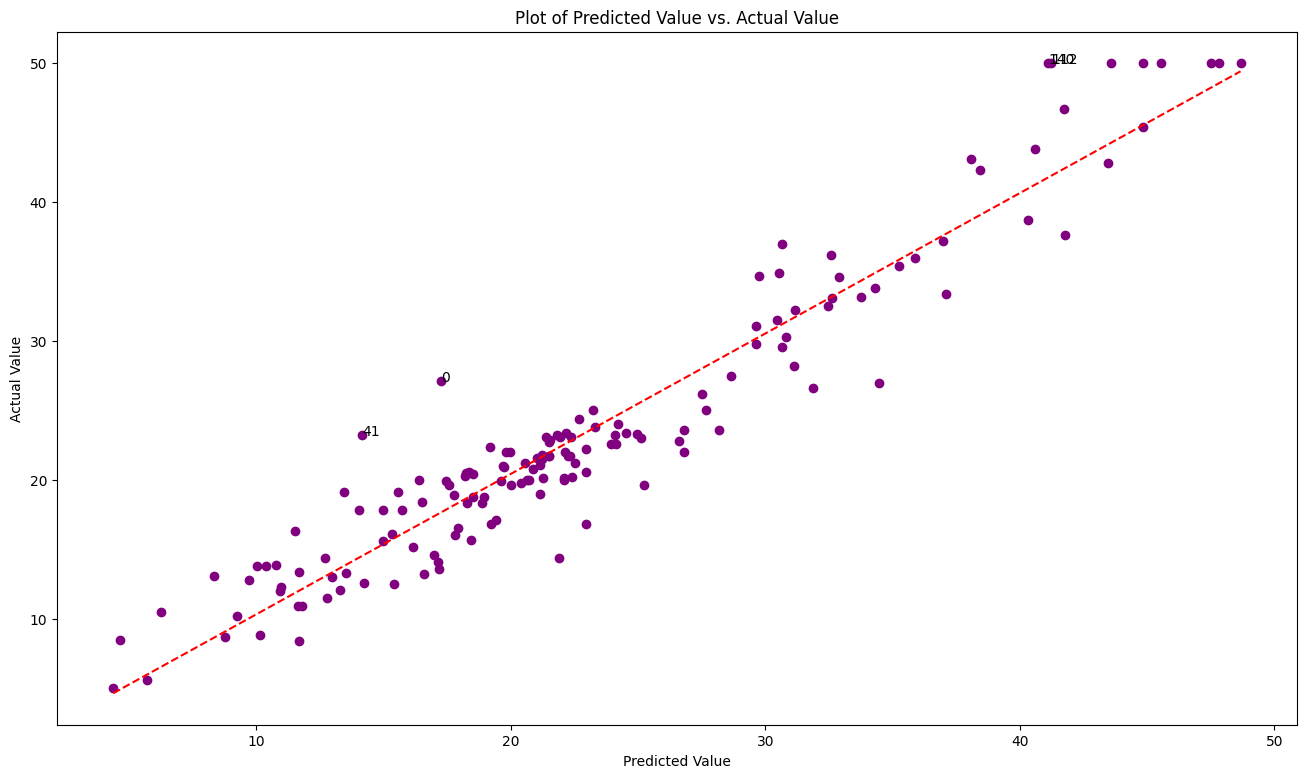

In [143]:
plot_scatter(preds_test.detach().numpy().reshape(-1),Y_test.reshape(-1),1,5,['Predicted Value','Actual Value'])